## Set up notebook

In [20]:
%env PYTHONHASHSEED=0
#import libaries
import numpy as np
from numpy.random import seed
import random as python_random
import tensorflow as tf

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
tf.random.set_seed(1234)

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras import backend as K
from keras import models

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, roc_auc_score
import itertools
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score

env: PYTHONHASHSEED=0


In [21]:
#set up function for confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
#set up evaluation metric functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Image Preprocessing (rescale, resize, reshape)

In [23]:
#create directory to train, test, val data
test_folder = '../data_val/test'
train_folder = '../data_val/train'
val_folder = '../data_val/val'

In [24]:
#rescale and resize train, val, test data
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(224,224), batch_size=3636)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(224,224), batch_size = 247)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(224,224), batch_size = 390) 

Found 3636 images belonging to 2 classes.
Found 247 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [25]:
#split data to images and labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [26]:
#reshape data
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

train_y = np.reshape(train_labels[:,0], (3636,1))
test_y = np.reshape(test_labels[:,0], (390,1))
val_y = np.reshape(val_labels[:,0], (247,1))

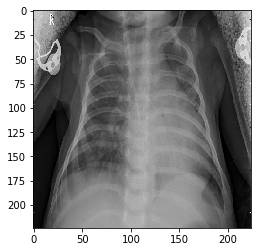

In [27]:
plt.imshow(train_images[123])

## Create model 

In [30]:
#build model
# seed(91)
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_shape=(150528,)))
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dropout(.35))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(.1))
model.add(layers.Dense(1, activation='sigmoid'))

## Train model

In [31]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives()])
history = model.fit(train_img, train_y,
                    epochs=10, batch_size = 25, validation_data= (val_img, val_y), verbose = 1)

Train on 3636 samples, validate on 247 samples
Epoch 1/10
3636/3636 [==============================] - 6s 2ms/step - loss: 0.8401 - acc: 0.6361 - precision_2: 0.6800 - recall_2: 0.8344 - true_positives_2: 1078.9795 - true_negatives_2: 71.6918 - val_loss: 0.6938 - val_acc: 0.5425 - val_precision_2: 0.6552 - val_recall_2: 0.9298 - val_true_positives_2: 2303.7000 - val_true_negatives_2: 83.0000
Epoch 2/10
3636/3636 [==============================] - 6s 2ms/step - loss: 0.6448 - acc: 0.6612 - precision_2: 0.6537 - recall_2: 0.9518 - true_positives_2: 3573.8425 - true_negatives_2: 83.0000 - val_loss: 0.7100 - val_acc: 0.5425 - val_precision_2: 0.6544 - val_recall_2: 0.9653 - val_true_positives_2: 4841.7002 - val_true_negatives_2: 83.0000
Epoch 3/10
3636/3636 [==============================] - 6s 2ms/step - loss: 0.6416 - acc: 0.6612 - precision_2: 0.6534 - recall_2: 0.9720 - true_positives_2: 6107.8838 - true_negatives_2: 83.0000 - val_loss: 0.7164 - val_acc: 0.5425 - val_precision_2: 0.654

## Evaluate model

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 25)                3763225   
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 182       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 15)                120       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 16        
Total params: 3,763,543
Trainable params: 3,763,543
Non-trainable params: 0
____________________________________________

In [33]:
results_train = model.evaluate(train_img, train_y)

3636/3636 [==============================] - 1s 227us/step


In [34]:
results_train

[0.6402593563229863,
 0.6611661314964294,
 0.6539291143417358,
 0.9934544563293457,
 26427.5,
 83.0]

In [35]:
results_val = model.evaluate(val_img,val_y)

247/247 [==============================] - 0s 229us/step


In [36]:
results_val

[0.7197934183997181,
 0.5425100922584534,
 0.6537229418754578,
 0.993754506111145,
 27686.375,
 83.0]

In [37]:
model.save('Step02c_model.h5')

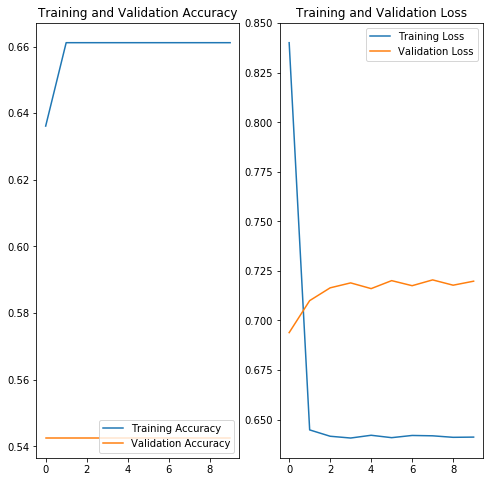

In [39]:
#Create a ROC curve
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix, without normalization
[[  0 113]
 [  0 134]]


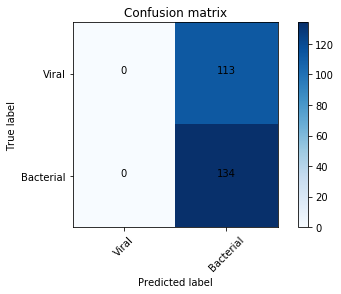

In [40]:
#Create a confusion matrix
y_pred = model.predict_classes(val_img)

cm = confusion_matrix(val_y, y_pred)
classes = ['Viral', 'Bacterial']
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix')

